В этом примере моделируется процесс обслуживания оборудования в мастерской. 

Будем моделировать работу двух ремонтников, которые обслуживают станки (3D-принтеры) в мастерской.

В этой модели полагаем, что единица модельного времени соответствует 1 минуте реального времени. Длительность работы модели - две недели

In [16]:
# -*- coding: utf-8 -*-
import random
import simpy

RANDOM_SEED = 4210
PT_MEAN = 20.0         # среднее время изготовления детали на станке
PT_SIGMA = 4.0         # ср.квадр.отклонение времени изготовления детали
MTTF = 1000.0          # среднее время между поломками (Mean Time To Failure)
REPAIR_TIME = 30.0     # среднее время ремонта станка
NUM_MACHINES = 5       # количество станков
WEEKS = 2              # время моделирования в неделях
SIM_TIME = WEEKS * 7 * 24 * 60  # время моделирования в минутах

fix_works =[]      # список времен 
at_work = False    # работники на работе?
men_at_work = []   # журнал состояния ремонтников

Модель станка состоит из двух процессов: рабочий процесс _workprocess()_ реализует фактическое поведение станка по изготовлению деталей; поломка станка периодически прерывает рабочий процесс, что имитируется сбоем _break_machine()_ .

Длительность изготовления детали на 3D-принтере оценивается как нормально распределенная случайная величина со средним 20 мин и станд.отклонением 4 мин. 

В мастерской есть пять идентичных станков. Станки в мастерской работают непрерывно и круглосуточно 24/7. 
Станки все время могут быть заняты изготовлением деталей, но каждый станок периодически может выходить из строя и требовать обслуживания.
Обслуживание одного станка выполняется одним ремонтником.

In [17]:
class Machine(object):
    def __init__(self, env, num, repairman):
        self.env = env
        self.parts_made = 0  # количество сделанных станком деталей
        self.broken = False  # станок не сломан!
        self.ID = num+1  # идентификатор станка
        self.repair_cnt = 0  # количество ремонтов станка
        self.totalFixDuration = 0  # общая длительность ремонтов
        self.totalFailureDuration = 0  # общая длительность простоев
        # запуск процессов работы и поломки станка
        self.workprocess = env.process(self.working(repairman))
        env.process(self.break_machine())

    def working(self, repairman):
        while True:
            # начало изготовления новой детали
            self.done_time = random.normalvariate(PT_MEAN, PT_SIGMA)
            while self.done_time:
                try:
                   # делаем деталь
                   self.start_work = self.env.now
                   yield self.env.timeout(self.done_time)
                   self.done_time = 0  # деталь доделана! =0
                except simpy.Interrupt:
                    self.broken = True  # станок сломан!
                    self.break_time = self.env.now  # время поломки станка
                    self.done_time -= self.env.now - self.start_work  # сколько времени осталось доделать деталь
                    with repairman.request(priority=10) as req:  # требуется ремонтник
                        yield req  # будем ждать ремонтника
                        self.repair_cnt +=1  # начался новый ремонт
                        self.fix_time = self.env.now  # время начала ремонта
                        yield self.env.timeout(random.uniform(REPAIR_TIME-10,REPAIR_TIME+10)) # длительность
                    self.broken = False   # станок восстановлен!
                    self.fix_duration =int(self.env.now - self.fix_time)  # длительность ремонта
                    self.failure_duration =int(self.env.now - self.break_time)  # длительность простоя из-за поломки
                    self.totalFixDuration +=self.fix_duration  # накопим общую длительность всех ремонтов
                    self.totalFailureDuration +=self.failure_duration  # накопим общую длительность всех простоев

            self.parts_made += 1  # станок сделал деталь

    def break_machine(self):
        # поломка станка
        while True:
           yield self.env.timeout(random.expovariate(1.0/MTTF))
           # не надо ломать уже поломанный станок!!
           if not self.broken: self.workprocess.interrupt()

Ремонтники работают по одной рабочей смене – 8 часов в день. 
Ремонт станка имеет приоритет 10, в то время как отдых имеет приоритет 1 (в simpy чем меньше число, тем выше приоритет).

In [18]:
def work_sched(env, repairman):
    global at_work, men_at_work
    rep =[0,]*repairman.capacity # список токенов "отдыха" ремонтников!
    # ремонтник выйдет на работу в 8ч
    # флаг - не работаю!
    at_work = False
    day_start = 8*60
    # до 8ч - отдых!
    # ремонтник "занят" отдыхом
    for r in range(repairman.capacity):
       rep[r] = repairman.request(priority=1)
       yield rep[r]
    men_at_work.append((int(at_work),env.now)) # запишем в журнал
    while True:
        # начинает новый день
        yield env.timeout(day_start)
        # ремонтник не "занят" отдыхом!
        for r in range(repairman.capacity):
            repairman.release(rep[r])
        # флаг - на работе!
        at_work = True
        day_work = 8*60  # длительность рабочего дня
        # рабочее время началось
        startworkperiod = env.now
        men_at_work.append((int(at_work),startworkperiod)) # запишем в журнал
        yield env.timeout(day_work)
        # флаг - не работаю!
        at_work = False
        # рабочее время закончилось,
        # ремонтник "занят" отдыхом
        for r in range(repairman.capacity):
           rep[r] = repairman.request(priority=1)
           yield rep[r]
        men_at_work.append((int(at_work),env.now)) # запишем в журнал
        # может быть переработка! поэтому
        # посчитаем начало след.рабочего дня через сутки
        day_start = (24-8)*60 -(env.now -startworkperiod -day_work)

Заготовка процесса мониторинга _(пока не используется?)_

In [19]:
# специальная функция для сбора данных
#def monitor(ev):
#   global men_at_work, fix_works
#   while True:
#      # запишем в журнал: (время, номер поломки, длительность ремонта, длительность поломки, состояние работника)
#      fix_works.append((ev.now, _))
#      yield ev.timeout(5.0)

Объявляем ресурс - ремонтник. Регистрируем процессы работы станков и расписание ремонтников. Запускаем модель

In [20]:
# настройка и выполнение модели
# random.seed(RANDOM_SEED)  # начальное значение ДСЧ
# создание среды и настройка процессов модели
env = simpy.Environment()

repairmen = simpy.PriorityResource(env, capacity=2)
machines = [Machine(env, i, repairmen) for i in range(NUM_MACHINES)]
env.process(work_sched(env, repairmen))
men_at_work = []   # журнал состояния ремонтников
# запуск модели
env.run(until=SIM_TIME)

# вывод результатов
print(f'Результаты работы цеха за {WEEKS} недели/ {SIM_TIME} мин')
for m in machines:  print(f'станок Prn_{m.ID} сделал {m.parts_made} деталей, прошел {m.repair_cnt} ремонтов')
print('Общее время простоев станков:', sum([m.totalFailureDuration for m in machines]))
print('Общее время ремонтов станков:', sum([m.totalFixDuration for m in machines]))

Результаты работы цеха за 2 недели/ 20160 мин
станок Prn_1 сделал 687 деталей, прошел 12 ремонтов
станок Prn_2 сделал 705 деталей, прошел 13 ремонтов
станок Prn_3 сделал 640 деталей, прошел 15 ремонтов
станок Prn_4 сделал 622 деталей, прошел 19 ремонтов
станок Prn_5 сделал 824 деталей, прошел 9 ремонтов
Общее время простоев станков: 30307
Общее время ремонтов станков: 2020


Построим графики состояния станков и ресурсов

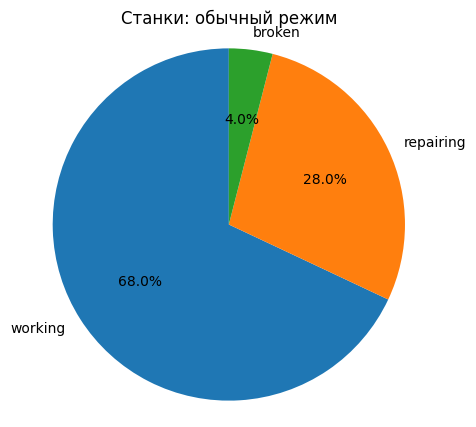

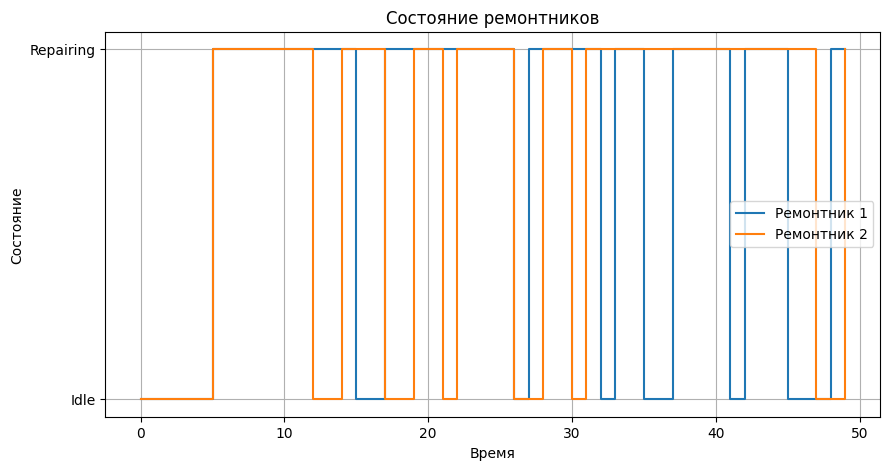

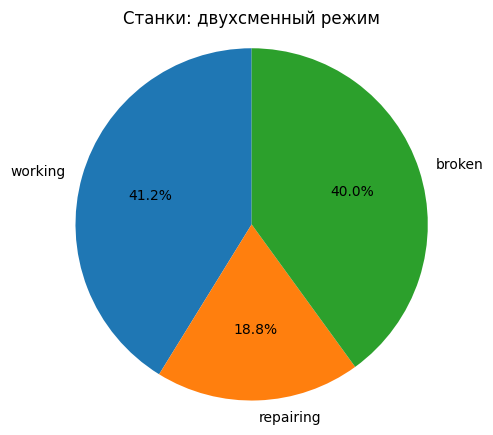

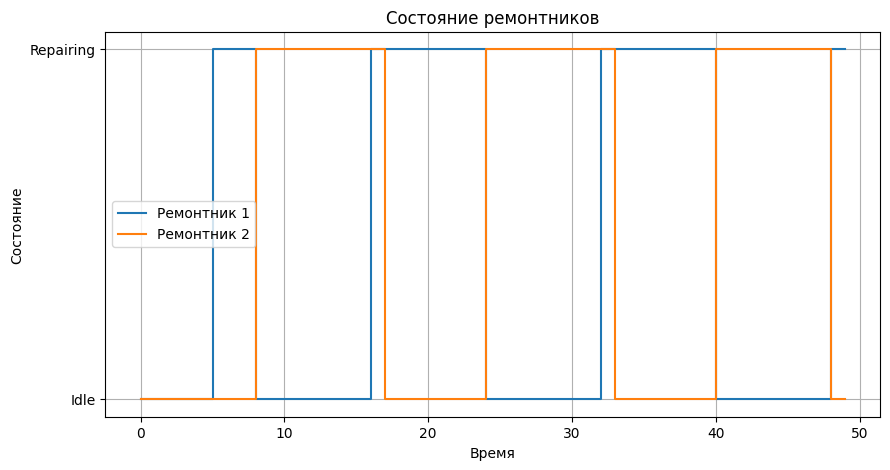

In [21]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots() # диаграммы на одну панель
# fig.set_figwidth(12)    #  ширина и
# fig.set_figheight(2)   #  высота "Figure"
# fig.set_facecolor('peachpuff')
# # График состояния работника
# ax.step([p[1] for p in men_at_work],[p[0] for p in men_at_work], lw=2,c='violet')
# ax.set_title('режим работы')
# ax.set_xlabel('время, час',loc='right')
# ax.set_ylabel('состояние')
# ax.set_yticks([0,-1],['работа','отдых'])
# ax.set_xticks([0,24*60,48*60,72*60,96*60,120*60,144*60,168*60,192*60,216*60,240*60,264*60,288*60],
#               ['0','24','48','72','96','120','144','168','192','216','240','264','288'])
# # диаграмма сделанных деталей
# lab, val =[],[]
# for m in machines:
#    lab.append(f'Eqp_{(m.ID)}\n{m.parts_made}')
#    val.append(m.parts_made)
# fig, bx = plt.subplots(1,4) # 4 диаграммы на одну панель в 1 ряд
# fig.set_figwidth(15)    #  ширина и
# fig.set_figheight(10)   #  высота "Figure"
# bx[0].set_title('сделано деталей')
# bx[0].pie(val, labels=lab, wedgeprops=dict(width=0.4,edgecolor='w'))
# # диаграмма сделанных ремонтов
# bx[1].set_title('кол-во ремонтов')
# bx[1].pie(val, labels=lab, wedgeprops=dict(width=0.7,edgecolor='black'))
# # диаграмма длит. ремонтов
# bx[2].set_title('длит.ремонтов')
# bx[2].pie(val, labels=lab, wedgeprops=dict(width=1,edgecolor='y'))
# # диаграмма сделанных простоев
# bx[3].set_title('длит.простоев')
# bx[3].pie(val, labels=lab, counterclock=False)

# plt.show()
# #plt.savefig('grafik.pdf', format='pdf', bbox_inches='tight')


import matplotlib.pyplot as plt
from collections import Counter
import random

# --- Классы модели ---

class Machine:
    def __init__(self):
        self.state = 'working'
        self.time_to_failure = random.randint(5, 10)
        self.time_to_repair = 0

    def step(self):
        if self.state == 'working':
            self.time_to_failure -= 1
            if self.time_to_failure <= 0:
                self.state = 'broken'
        elif self.state == 'repairing':
            self.time_to_repair -= 1
            if self.time_to_repair <= 0:
                self.state = 'working'
                self.time_to_failure = random.randint(5, 10)

class Repairman:
    def __init__(self, id):
        self.id = id
        self.state = 'idle'
        self.current_machine = None
        self.time_remaining = 0

    def assign(self, machine):
        self.state = 'repairing'
        self.current_machine = machine
        self.time_remaining = random.randint(2, 5)
        machine.state = 'repairing'
        machine.time_to_repair = self.time_remaining

    def step(self):
        if self.state == 'repairing':
            self.time_remaining -= 1
            if self.time_remaining <= 0:
                self.state = 'idle'
                self.current_machine = None

def is_on_shift(repairman_id, time):
    shift_duration = 8
    shift_cycle = 16
    if repairman_id % 2 == 0:
        return (time % shift_cycle) < shift_duration
    else:
        return shift_duration <= (time % shift_cycle) < 2 * shift_duration

def simulate(sim_time=50, two_shifts=False):
    machines = [Machine() for _ in range(5)]
    repairmen = [Repairman(i) for i in range(2)]

    machine_states_over_time = []
    repairman_states_over_time = []

    for t in range(sim_time):
        for m in machines:
            m.step()

        for r in repairmen:
            r.step()

        for m in machines:
            if m.state == 'broken':
                for r in repairmen:
                    if r.state == 'idle':
                        if two_shifts and not is_on_shift(r.id, t):
                            continue
                        r.assign(m)
                        break

        machine_states_over_time.append([m.state for m in machines])
        repairman_states_over_time.append([r.state for r in repairmen])

    return machine_states_over_time, repairman_states_over_time

def plot_machine_state_pie(machine_states_over_time, title=""):
    flat = [s for sub in machine_states_over_time for s in sub]
    counts = Counter(flat)
    labels = counts.keys()
    sizes = counts.values()
    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.axis('equal')
    plt.show()

def plot_repairman_step_chart(repairman_states_over_time):
    state_map = {"idle": 0, "repairing": 1}
    plt.figure(figsize=(10, 5))
    for idx, states in enumerate(zip(*repairman_states_over_time)):
        numeric_states = [state_map[s] for s in states]
        plt.step(range(len(numeric_states)), numeric_states, where='post', label=f"Ремонтник {idx+1}")
    plt.yticks([0, 1], ["Idle", "Repairing"])
    plt.xlabel("Время")
    plt.ylabel("Состояние")
    plt.title("Состояние ремонтников")
    plt.legend()
    plt.grid(True)
    plt.show()

# За и сравнение
machines_1, repairmen_1 = simulate(two_shifts=False)
plot_machine_state_pie(machines_1, "Станки: обычный режим")
plot_repairman_step_chart(repairmen_1)

machines_2, repairmen_2 = simulate(two_shifts=True)
plot_machine_state_pie(machines_2, "Станки: двухсменный режим")
plot_repairman_step_chart(repairmen_2)



# Логику симуляции

# Графики

# Двухсменную конфигурацию

# Сравнение двух режимов